In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("Network_data.csv", sep=";", decimal=",")
df

,FLOW_ID,PROTOCOL_MAP,L4_SRC_PORT,IPV4_SRC_ADDR,L4_DST_PORT,IPV4_DST_ADDR,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LAST_SWITCHED,PROTOCOL,...,TOTAL_PKTS_EXP,TOTAL_BYTES_EXP,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,ANALYSIS_TIMESTAMP,ANOMALY,ALERT,ID
0,372018590,udp,53950,10.114.232.40,53,10.114.226.5,1647760833,1,1647760833,17,...,0,0,165,2,275,2,1647760873,0.0,None,0
1,368604472,tcp,37914,10.114.241.166,38303,10.114.224.218,1647686725,1,1647686725,6,...,0,0,44,1,40,1,1647687338,0.0,Port Scanning,1
2,367513992,tcp,33216,10.114.241.166,18757,10.114.224.116,1647680044,0,1647680044,6,...,0,0,44,1,40,1,1647680115,1.0,Port Scanning,2
3,371997670,udp,48627,10.114.225.205,53,10.114.226.5,1647760172,0,1647760172,17,...,0,0,128,2,160,2,1647760207,0.0,None,3
4,374311119,udp,35939,10.114.225.205,53,10.114.226.5,1647780916,0,1647780916,17,...,0,0,172,2,300,2,1647780984,0.0,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213716,369777076,tcp,9090,49.88.112.109,22,10.114.225.206,1647697117,0,1647697117,6,...,0,0,40,1,40,1,1647697169,0.0,None,213716
213718,369951971,tcp,48050,10.114.225.201,443,3.68.18.70,1647700921,110025,1647701031,6,...,0,0,1960,25,2378,13,1647701099,0.0,None,213718
213720,374268311,tcp,54898,89.248.165.97,16411,10.114.224.235,1647779778,51,1647779778,6,...,0,0,80,2,40,1,1647779832,0.0,None,213720
213721,369608959,tcp,48872,10.114.225.206,443,172.67.164.146,1647693306,205,1647693306,6,...,0,0,1465,13,4280,10,1647693357,0.0,None,213721


# the head rows of the dataframe.

In [3]:
df.head()

,FLOW_ID,PROTOCOL_MAP,L4_SRC_PORT,IPV4_SRC_ADDR,L4_DST_PORT,IPV4_DST_ADDR,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LAST_SWITCHED,PROTOCOL,...,TOTAL_PKTS_EXP,TOTAL_BYTES_EXP,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,ANALYSIS_TIMESTAMP,ANOMALY,ALERT,ID
0,372018590,udp,53950,10.114.232.40,53,10.114.226.5,1647760833,1,1647760833,17,...,0,0,165,2,275,2,1647760873,0.0,None,0
1,368604472,tcp,37914,10.114.241.166,38303,10.114.224.218,1647686725,1,1647686725,6,...,0,0,44,1,40,1,1647687338,0.0,Port Scanning,1
2,367513992,tcp,33216,10.114.241.166,18757,10.114.224.116,1647680044,0,1647680044,6,...,0,0,44,1,40,1,1647680115,1.0,Port Scanning,2
3,371997670,udp,48627,10.114.225.205,53,10.114.226.5,1647760172,0,1647760172,17,...,0,0,128,2,160,2,1647760207,0.0,None,3
4,374311119,udp,35939,10.114.225.205,53,10.114.226.5,1647780916,0,1647780916,17,...,0,0,172,2,300,2,1647780984,0.0,None,4


# Encoder : 

In [4]:
from sklearn import preprocessing

# Apply Leabl encoding
le = preprocessing.LabelEncoder()
le.fit(df['IPV4_SRC_ADDR'])
df['IPV4_SRC_ADDR']=le.transform(df['IPV4_SRC_ADDR'])

le.fit(df['IPV4_DST_ADDR'])
df['IPV4_DST_ADDR']=le.transform(df['IPV4_DST_ADDR'])

from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoding
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[['PROTOCOL_MAP']])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['PROTOCOL_MAP']))
final_df = df.join(encoded_df)
final_df.drop('PROTOCOL_MAP', axis=1, inplace=True)

# fill 0 in one-hot encoding
final_df['PROTOCOL_MAP_udp'] = final_df['PROTOCOL_MAP_udp'].fillna(0)
final_df['PROTOCOL_MAP_tcp'] = final_df['PROTOCOL_MAP_tcp'].fillna(0)
final_df['PROTOCOL_MAP_gre'] = final_df['PROTOCOL_MAP_gre'].fillna(0)
final_df['PROTOCOL_MAP_icmp'] = final_df['PROTOCOL_MAP_icmp'].fillna(0)
final_df['PROTOCOL_MAP_ipv6-icmp'] = final_df['PROTOCOL_MAP_ipv6-icmp'].fillna(0)


# Split the dataset into Train and Test sets with test_size=30% and random_state=23

In [5]:
from sklearn.model_selection import train_test_split
X = final_df.drop('ALERT',axis=1)
y = final_df['ALERT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=11)

# DecisionTree

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score , ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)

print("--Decision Trees--\n")
print(" confusion matrix : \n",confusion_matrix(y_test,predictions) , "\n")
print("accuracy : ",accuracy_score(y_test,predictions)*100)

--Decision Trees--

 confusion matrix : 
 [[    2     0     0]
 [    0 27596     0]
 [    0     1  7553]] 

accuracy :  99.99715521165226


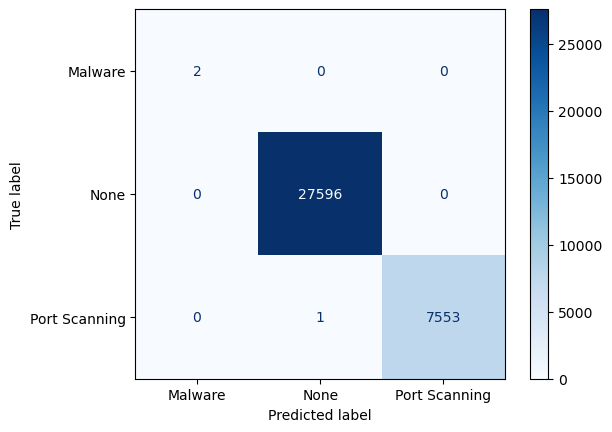

In [25]:
display_dtree=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predictions),display_labels=dtree.classes_)
display_dtree.plot(cmap=plt.cm.Blues)
plt.show()

# GaussianNB

In [8]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
 
y_pred = gnb.predict(X_test)
print("--Naive Bayes Classifiers--\n")
print(" confusion matrix : \n",confusion_matrix(y_test,y_pred), "\n")
print("accuracy : ",accuracy_score(y_test,y_pred)*100)

--Naive Bayes Classifiers--

 confusion matrix : 
 [[    2     0     0]
 [    0 27411   185]
 [    0     3  7551]] 

accuracy :  99.46517979062358


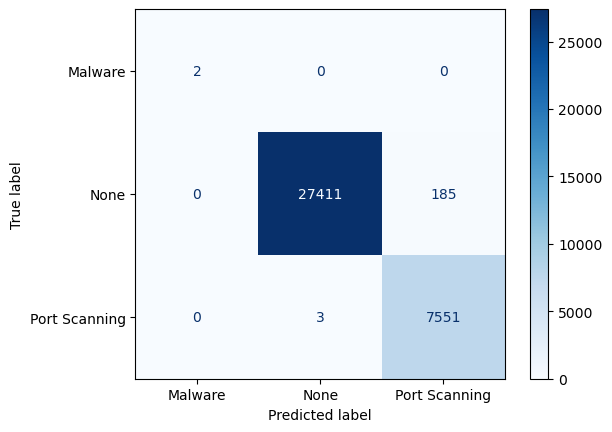

In [23]:
display_gnb=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),display_labels=gnb.classes_ )
display_gnb.plot(cmap=plt.cm.Blues)
plt.show()

# RandomForest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 20, criterion = 'gini', max_depth = 4) 
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print("--Random Forests--\n")
print(" confusion matrix : \n",confusion_matrix(y_test,rfc_pred) , "\n")
print("accuracy : ",accuracy_score(y_test,rfc_pred)*100)

--Random Forests--

 confusion matrix : 
 [[    2     0     0]
 [    0 27569    27]
 [    0     4  7550]] 

accuracy :  99.91181156121985


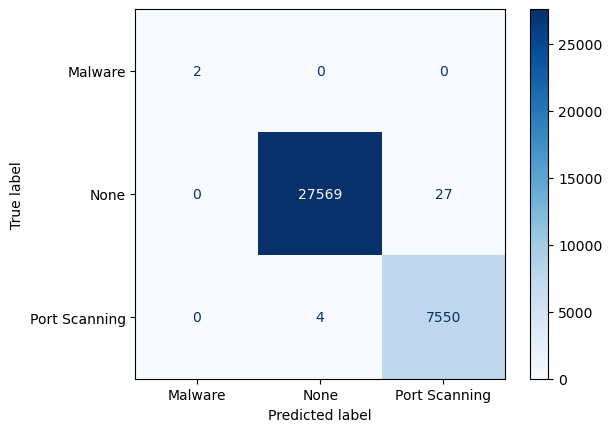

In [24]:
display_rfc=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,rfc_pred),display_labels=rfc.classes_)
display_rfc.plot(cmap=plt.cm.Blues)
plt.show()

# Conclusion

### Since we need to classify network connections, we used Algorithm Classification, so we tried KNeighbour, GaussianNB, RandomForest, Support Vector Machine, and DecisionTree. We found the highest accuracy percentage in the algorithms, that is  DecisionTree , GaussianNB, Random Forests, ..Respectively